In [ ]:
import re
import warnings
import duckdb

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib as mpl

from typing import List
from scipy import integrate
from datetime import datetime, time, timedelta

from matplotlib import pyplot as plt
from matplotlib import font_manager as fm

warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
FIGSIZE_ACM_SMALL = (3.33, 2.06)
FIGSIZE_ACM_LARGE = (7.00, 2.06)

flare = sns.color_palette("flare", 4)
colors = [flare[3], flare[1]]

sns.reset_defaults()
pd.options.display.float_format = '{:.5f}'.format
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Linux Libertine"],
    "text.usetex": True,
    "text.latex.preamble": r"\usepackage{libertine}",
    "mathtext.fontset": "custom",
    "mathtext.rm": "Linux Libertine",
    "mathtext.it": "Linux Libertine:italic",
    "mathtext.bf": "Linux Libertine:bold",
})

plt.rcParams.update({
    'font.size': 10,
    'axes.labelsize': 10,
    'axes.titlesize': 10,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.titlesize': 10
})


Für `data_static` Pi 5 rausfiltern, für `data_dynamic` Nummer 2 (?) rausfiltern

In [ ]:
def data_consumption(kind: str, melt: bool, raw: bool = False) -> pd.DataFrame:

    data = []
    with open(f"./data_{kind}/pi0/{kind}/consumption.log") as f:
        for line in f:
            data.append(re.findall(r"([-+]?\d*\.\d+|\d+)", line))
    df = pd.DataFrame(data=data, columns=["time", "V1", "A1", "V2", "A2", "V3", "A3", "V4", "A4", "V5", "A5"])
    
    df["time"] = df["time"].astype(np.float64)
    for i in range(1,6):
        df[f"W{i}"] = df[f"V{i}"].astype(np.float64) * df[f"A{i}"].astype(np.float64)

    if raw:
        return df

    if melt:
        df = pd.melt(df, id_vars="time", value_vars=[f"W{i}" for i in range(1, 6)], var_name="pi", value_name="W")
        label_map = {"W1": "1", "W2": "2", "W3": "3", "W4": "4", "W5": "5"}
        df["pi"] = df["pi"].replace(label_map)
    
    else:
        df["W"] = df["W1"] + df["W2"] + df["W3"] + df["W4"] + df["W5"]
        df = df.drop(["V1", "A1", "V2", "A2", "V3", "A3", "V4", "A4", "V5", "A5", "W1", "W2", "W3", "W4", "W5"], axis=1)
        
        df["time"] = pd.to_datetime(df["time"], unit="s")
        df = df.set_index("time")
        df = df.resample("1S").mean()
        df = df.reset_index(False)
        
        df["time"] = pd.to_numeric(df["time"])/10**9
        df["time"] = df["time"].astype(int)
        df["time"] = df["time"] - df["time"].min()
        
        df = df.dropna(subset=["W"])
        df["W"] = df["W"].interpolate()

    return df

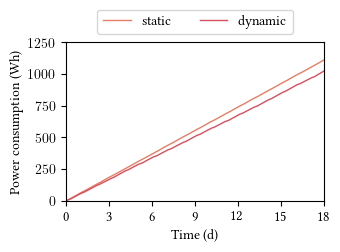

In [ ]:
data_dynamic = data_consumption("dynamic", False)
data_dynamic["J"] = integrate.cumulative_trapezoid(y=data_dynamic["W"], x=data_dynamic["time"], initial=0)
data_dynamic["Wh"] = data_dynamic["J"]/3_600

data_static = data_consumption("static", False)
data_static["J"] = integrate.cumulative_trapezoid(y=data_static["W"], x=data_static["time"], initial=0)
data_static["Wh"] = data_static["J"]/3_600

def plot_consumption_cluster_total(data_static: pd.DataFrame, data_dynamic: pd.DataFrame, colors: list) -> None:

    fig, ax = plt.subplots(figsize=FIGSIZE_ACM_SMALL)

    sns.lineplot(x="time", y="Wh", data=data_static, ax=ax, label="static", color=colors[0], linewidth=1)
    sns.lineplot(x="time", y="Wh", data=data_dynamic, ax=ax, label="dynamic", color=colors[1], linewidth=1)

    #plt.fill_between(
    #    x=data_static["time"], 
    #    y1=data_static["Wh"], 
    #    y2=data_dynamic["Wh"][:len(data_static["Wh"])], 
    #    color="green", alpha=0.25
    #)
    
    xlim = 86_400 * 3
    ax.set_xlabel("Time (d)")
    ax.set_xlim(0, xlim)
    ax.set_xticks(
        ticks=range(0, xlim+1, xlim//6),
        labels=range(0, 18+1, 3)
    )

    ylim = 1250
    ax.set_ylabel("Power consumption (Wh)")
    ax.set_ylim(0, ylim)

    ax.grid(False)

    ax.legend(
        loc="upper center",
        ncols=2,
        bbox_to_anchor=(0.5, 1.25),
        reverse = False,
        frameon = True,
        fancybox = True,
    )

    plt.show()
    #fig.savefig("../2025-paper-HaveYouTriedTurningItOff/graphs/consumption_cluster_total.pdf", bbox_inches="tight")
    plt.close()

plot_consumption_cluster_total(data_static, data_dynamic, colors=colors)

In [ ]:
dfs = data_consumption(kind="static", melt=False, raw=True)
dfs["nodes_active"] = (dfs["W1"] != 0).astype(np.int64) + (dfs["W2"] != 0) + (dfs["W3"] != 0) + (dfs["W4"] != 0) + (dfs["W5"] != 0)
dfs["nodes_active_scaled"] = dfs["nodes_active"] * 5
dfs["W"] = dfs["W1"] + dfs["W2"] + dfs["W3"] + dfs["W4"] + dfs["W5"]
dfs["time"] = dfs["time"]-dfs["time"].min()

dfd = data_consumption(kind="dynamic", melt=False, raw=True)
dfd["nodes_active"] = (dfd["W1"] != 0).astype(np.int64) + (dfd["W2"] != 0) + (dfd["W3"] != 0) + (dfd["W4"] != 0) + (dfd["W5"] != 0)
dfd["nodes_active_scaled"] = dfd["nodes_active"] * 5
dfd["W"] = dfd["W1"] + dfd["W2"] + dfd["W3"] + dfd["W4"] + dfd["W5"]
dfd["time"] = dfd["time"]-dfd["time"].min()

def plot_power_draw_24h(df: pd.DataFrame, colors: list, filename: str) -> None:

    fig, ax1 = plt.subplots(figsize=FIGSIZE_ACM_SMALL)
    ax2 = ax1.twinx()

    sns.lineplot(x="time", y="W", data=df, ax=ax1, linestyle="-", color=colors[0], label="power", linewidth=1)
    sns.lineplot(x="time", y="nodes_active_scaled", data=df, ax=ax1, linestyle="-", color=colors[1], label="nodes", linewidth=1)
    
    ax1.set_ylabel("Power (W)")
    ax1.set_ylim(0, 25)

    ax2.set_ylabel("Active nodes")
    ax2.set_ylim(0, 5)

    xlim = 86_400 // 6
    ax1.set_xlabel("Time (h)")
    ax1.set_xlim(xlim, xlim*2)
    ax1.set_xticks(
        ticks=range(xlim, 2*xlim+1, xlim//6),
        labels=range(0, 24+1, 4)
    )
    
    ax1.legend(
        loc="upper center",
        ncols=2,
        bbox_to_anchor=(0.5, 1.25),
        reverse = False,
        frameon = True,
        fancybox = True,
    )
    
    fig.savefig(filename, bbox_inches="tight")
    plt.close()

plot_power_draw_24h(dfs, colors, "power_draw_24h_static.pdf")
plot_power_draw_24h(dfd, colors, "power_draw_24h_dynamic.pdf")

In [ ]:
def data_invocations(kind: str) -> pd.DataFrame:

    def start_stop(line: str) -> (str, str):
        line = line.strip()
        contents = line.split(", ")
        contents = contents[1:]
        start, stop = contents[0].split(".")[0], contents[1].split(".")[0]
        return start, stop
    
    base_date = datetime.strptime("1970-01-01", "%Y-%m-%d").date()
    data = []
    for i in range(4):
        start_date = base_date
        last_start = None
        with open(f"./data_{kind}/pi{i}/{kind}/fn_invocations.log") as f:
            counter = 0
            for line in f:
                start, stop = start_stop(line)
                if last_start and int(last_start[:2]) == 23 and int(start[:2]) == 0:
                    start_date += timedelta(days=1)
                date_stop = start_date
                if int(start[:2]) > int(stop[:2]):
                    date_stop += timedelta(days=1)
                t_start = datetime.strptime(f"{start_date} {start}", "%Y-%m-%d %H:%M:%S")
                t_stop = datetime.strptime(f"{date_stop} {stop}", "%Y-%m-%d %H:%M:%S")
                data.append([int(t_start.timestamp()), int(t_stop.timestamp()), i])
                last_start = start
                counter += 1
    return pd.DataFrame(data=data, columns=["time_start", "time_stop", "pi"])

In [ ]:
data_invocations("dynamic").head()

,time_start,time_stop,pi
0,59797,59805,0
1,59797,59805,0
2,59799,59808,0
3,59799,59808,0
4,59800,59810,0


259203 312221


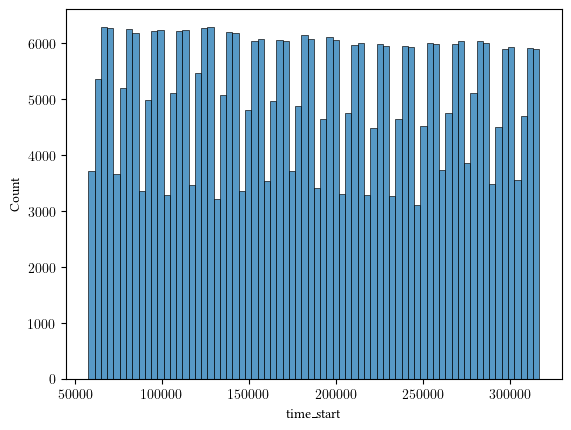

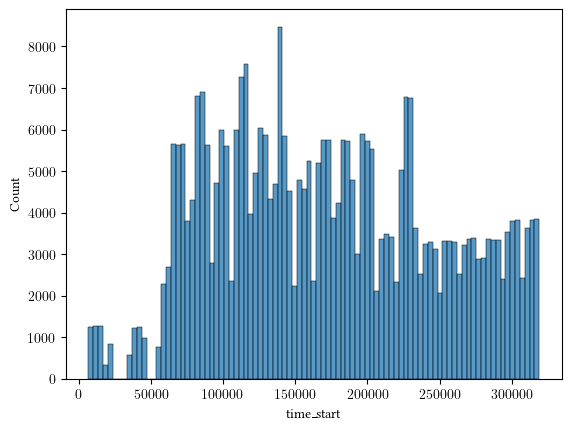

In [ ]:
bucket_size = "1s"

dfs = data_invocations("static")
#dfs["time"] = pd.to_datetime(dfs["time_start"], unit="s")
#dfs["time"] = dfs["time"].dt.floor(bucket_size)
#dfs["time"] = (dfs["time"] - dfs["time"].min()).dt.total_seconds().astype(int)
#dfs = dfs.groupby(["time"]).size().reset_index(name="count")

dfd = data_invocations("dynamic")
#dfd["time"] = pd.to_datetime(dfd["time_start"], unit="s")
#dfd["time"] = dfd["time"].dt.floor(bucket_size)
#dfd["time"] = (dfd["time"] - dfd["time"].min()).dt.total_seconds().astype(int)
#dfd = dfd.groupby(["time"]).size().reset_index(name="count")

print(dfs["time_start"].max()-dfs["time_start"].min(), dfd["time_start"].max()-dfd["time_start"].min())

sns.histplot(dfs["time_start"])
plt.show()
sns.histplot(dfd["time_start"])
plt.show()


#fig, ax = plt.subplots(figsize=FIGSIZE_ACM_LARGE)

#print(len(dfs), len(dfd))

#sns.lineplot(x="time", y="count", data=dfd, ax=ax, label="dynamic")
#sns.lineplot(x="time", y="count", data=dfs, ax=ax, label="static")

#plt.show()

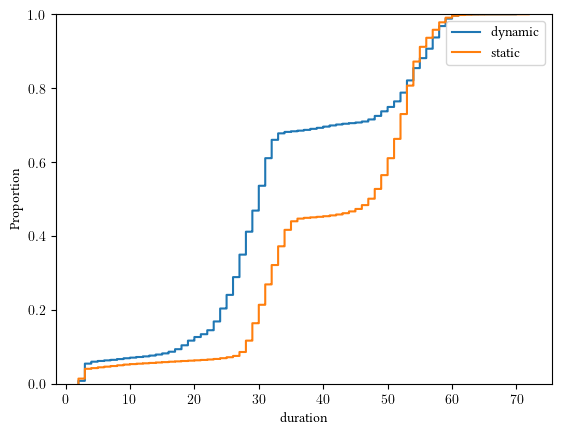

In [ ]:
dfd = data_invocations("dynamic")
dfd["duration"] = dfd["time_stop"] - dfd["time_start"]

dfs = data_invocations("static")
dfs["duration"] = dfs["time_stop"] - dfs["time_start"]

sns.ecdfplot(dfd["duration"], label="dynamic")
sns.ecdfplot(dfs["duration"], label="static")
plt.legend()
plt.show()

In [ ]:
df = pd.DataFrame(data={
    "time": data_dynamic["time"],
    "W_dynamic": data_dynamic["W"],
    "W_static": data_static["W"],
})
df["savings"] = 1-df["W_dynamic"]/df["W_static"]

In [ ]:
a, b = data_static["Wh"].max(), data_dynamic["Wh"].max()
(1-b/a)*100, a, b

(np.float64(7.8511877691722525),
 np.float64(1110.6165233077081),
 np.float64(1023.4199346673672))

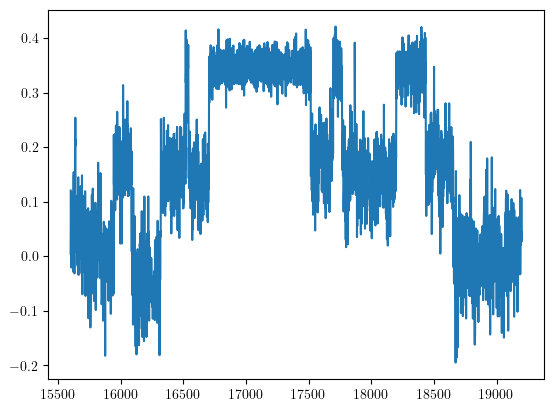

(np.float64(0.16818415211499751), np.float64(0.14653734339582758))

In [ ]:
df.head(n=10)

dff = df[df["time"] < (86_400/6/24*32)]
dff = dff[dff["time"] >= (86_400/6/24*26)]
len(dff), (32-26)*600

plt.plot(dff["time"], dff["savings"])
plt.show()

dff["savings"].mean(), dff["savings"].std()

In [ ]:
df["savings"].mean()

np.float64(0.08751615165700793)

In [ ]:
data_dynamic.head(n=10)

,time,W,J,Wh
0,0,5.93782,0.00000,0.00000
1,1,6.15616,6.04699,0.00168
2,2,6.02508,12.13761,0.00337
3,3,5.22179,17.76105,0.00493
4,4,4.94693,22.84541,0.00635
5,5,5.19156,27.91465,0.00775
6,6,5.10881,33.06484,0.00918
7,7,5.59514,38.41681,0.01067
8,8,5.21613,43.82245,0.01217
9,9,5.12296,48.99199,0.01361


#### Plot Leistung gesamte Cluster mit Clustergröße

In [ ]:
# neuer consumption/node count plot aber direkt 2 in 1

dfs = data_consumption(kind="static", melt=False, raw=True)
dfs["nodes_active"] = (dfs["W1"] != 0).astype(np.int64) + (dfs["W2"] != 0) + (dfs["W3"] != 0) + (dfs["W4"] != 0) + (dfs["W5"] != 0)
dfs["nodes_active_scaled"] = dfs["nodes_active"] * 5
dfs["W"] = dfs["W1"] + dfs["W2"] + dfs["W3"] + dfs["W4"] + dfs["W5"]
dfs["time"] = dfs["time"]-dfs["time"].min()

dfd = data_consumption(kind="dynamic", melt=False, raw=True)
dfd["nodes_active"] = (dfd["W1"] != 0).astype(np.int64) + (dfd["W2"] != 0) + (dfd["W3"] != 0) + (dfd["W4"] != 0) + (dfd["W5"] != 0)
dfd["nodes_active_scaled"] = dfd["nodes_active"] * 5
dfd["W"] = dfd["W1"] + dfd["W2"] + dfd["W3"] + dfd["W4"] + dfd["W5"]
dfd["time"] = dfd["time"]-dfd["time"].min()

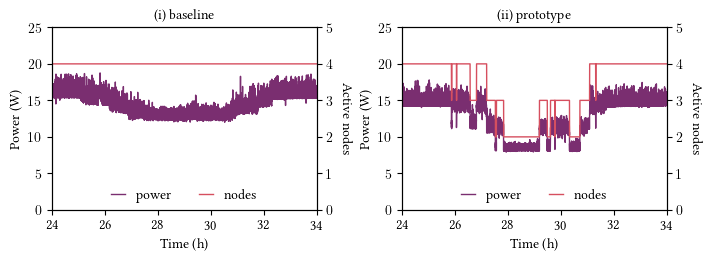

In [ ]:
def plot_power_subplots(dfs: pd.DataFrame, dfd: pd.DataFrame, colors: list, filename: str) -> None:

    # fig, (ax1a, ax2a) = plt.subplots(figsize=FIGSIZE_ACM_LARGE, ncols=2, nrows=1, constrained_layout=True)
    fig, (ax1a, ax2a) = plt.subplots(figsize=(7, 2.5), ncols=2, nrows=1, constrained_layout=True)

    sns.lineplot(x="time", y="W", data=dfs, ax=ax1a, linestyle="-", color=colors[0], label="power", linewidth=1)
    sns.lineplot(x="time", y="nodes_active_scaled", data=dfs, ax=ax1a, linestyle="-", color=colors[1], label="nodes", linewidth=1)

    sns.lineplot(x="time", y="W", data=dfd, ax=ax2a, linestyle="-", color=colors[0], label="power", linewidth=1)
    sns.lineplot(x="time", y="nodes_active_scaled", data=dfd, ax=ax2a, linestyle="-", color=colors[1], label="nodes", linewidth=1)

    ax1b = ax1a.twinx()
    ax2b = ax2a.twinx()

    ax1a.set_ylabel("Power (W)")
    ax2a.set_ylabel("Power (W)")
    ax1b.set_ylabel("Active nodes", rotation=270, rotation_mode=None, verticalalignment="center", horizontalalignment="left")
    ax2b.set_ylabel("Active nodes", rotation=270, rotation_mode=None, verticalalignment="center", horizontalalignment="left")

    ax1a.set_xlabel("Time (h)")
    ax2a.set_xlabel("Time (h)")

    ax1a.set_ylim(0, 25)
    ax2a.set_ylim(0, 25)
    ax1b.set_ylim(0, 5)
    ax2b.set_ylim(0, 5)

    ax1a.set_title("(i) baseline")
    ax2a.set_title("(ii) prototype")

    secs = lambda h: int(60*60*h/6)

    ll, ul = 24, 34
    xsteps = 5
    
    ax1a.set_xlim(secs(ll), secs(ul))
    ax2a.set_xlim(secs(ll), secs(ul))
    
    ax1a.set_xticks(
        ticks=range(secs(ll), secs(ul)+1, int((secs(ul)-secs(ll))//(xsteps))), 
        labels=range(ll, ul+1, int((ul-ll)//(xsteps)))
    )
    ax2a.set_xticks(
        ticks=range(secs(ll), secs(ul)+1, int((secs(ul)-secs(ll))//(xsteps))), 
        labels=range(ll, ul+1, int((ul-ll)//(xsteps)))
    )

    ax1a.legend(
        loc="lower center",
        ncols=2,
        frameon=False,
        fancybox=True,
        bbox_to_anchor=(0.5, -0.025),
        handlelength=1 
    )

    ax2a.legend(
        loc="lower center",
        ncols=2,
        frameon=False,
        fancybox=True,
        bbox_to_anchor=(0.5, -0.025),
        handlelength=1
    )

    # fig.subplots_adjust(wspace=0.4)

    fig.savefig(filename)
    plt.show()
    plt.close()


plot_power_subplots(dfs, dfd, colors, "../2025-paper-HaveYouTriedTurningItOff/graphs/subplots_power_draw.pdf")

#### Vergleich Energieverbrauch gesamte Cluster 

In [ ]:
data_dynamic = data_consumption("dynamic", False)
data_dynamic["J"] = integrate.cumulative_trapezoid(y=data_dynamic["W"], x=data_dynamic["time"], initial=0)
data_dynamic["Wh"] = data_dynamic["J"]/3_600

data_static = data_consumption("static", False)
data_static["J"] = integrate.cumulative_trapezoid(y=data_static["W"], x=data_static["time"], initial=0)
data_static["Wh"] = data_static["J"]/3_600

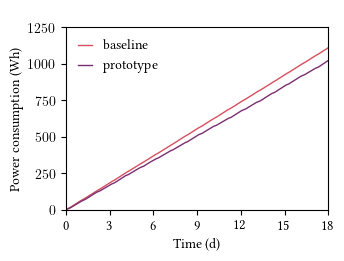

In [ ]:
def plot_consumption_cluster_total(data_static: pd.DataFrame, data_dynamic: pd.DataFrame, colors: list) -> None:

    fig, ax = plt.subplots(
        figsize=(3.33, 2.5), 
        constrained_layout=True
    )

    sns.lineplot(x="time", y="Wh", data=data_static, ax=ax, label="baseline", color=colors[1], linewidth=1)
    sns.lineplot(x="time", y="Wh", data=data_dynamic, ax=ax, label="prototype", color=colors[3], linewidth=1)

    ax.set_title(" ", color="white")

    xlim = 86_400 * 3
    ax.set_xlabel("Time (d)")
    ax.set_xlim(0, xlim)
    ax.set_xticks(
        ticks=range(0, xlim+1, xlim//6),
        labels=range(0, 18+1, 3)
    )

    ylim = 1250
    ax.set_ylabel("Power consumption (Wh)")
    ax.set_ylim(0, ylim)

    ax.grid(False)

    ax.legend(
        loc="upper left",
        frameon=False,
        markerfirst=True,
        handlelength=1
    )

    fig.savefig("../2025-paper-HaveYouTriedTurningItOff/graphs/consumption_cluster_total.pdf")
    plt.show()
    plt.close()

plot_consumption_cluster_total(data_static, data_dynamic, colors=colors)

#### Visualisierung Inputdaten

In [ ]:
def data_input(n_days: int) -> pd.DataFrame:
    data = []
    for i in range(n_days):
        data.append(pd.read_csv(f"./inputdata/requests_second/day_00{i}.csv"))
    df = pd.concat(data)
    df["total"] = df.loc[:, "0":"199"].astype(float).sum(axis=1)
    return df

df = data_input(7)

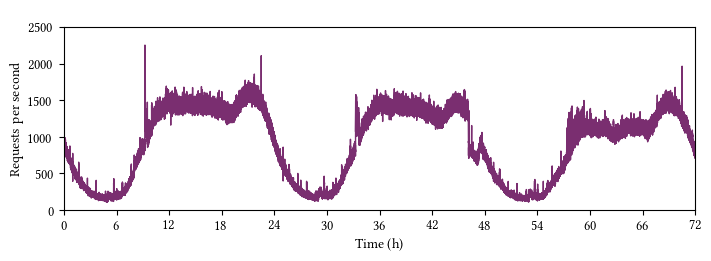

In [ ]:
def plot_input_requests_function(df: pd.DataFrame, function_id: int, colors: list, filename: str, smoothing: int = 1) -> None:

    fig, ax = plt.subplots(
        nrows=1,
        ncols=1,
        # figsize=FIGSIZE_ACM_LARGE,
        figsize=(7, 2.5),
        constrained_layout=True
    )

    df = df.copy()
    df = df[df["time"] < 86_400*3]
    df[f"{function_id}"] = df[f"{function_id}"].rolling(window=smoothing, min_periods=1).mean()

    sns.lineplot(x="time", y=f"{function_id}", data=df, ax=ax, linewidth=1, color=colors[3])

    ax.set_title(" ") #for same height as other plots
    ax.set_ylabel("Requests per second")
    ax.set_xlabel("Time (h)")

    ax.set_ylim(0, 2500)
    ax.set_yticks(
        ticks=range(0, 2500+1, 500),
        labels=range(0, 2500+1, 500)
    )

    secs = lambda h: int(60*60*h)

    ll, ul = 0, 72
    xsteps = 12
    
    ax.set_xlim(secs(ll), secs(ul))
    ax.set_xticks(
        ticks=range(
            secs(ll),
            secs(ul)+1,
            int((secs(ul)-secs(ll))//xsteps)
        ),
        labels=range(
            ll,
            ul+1,
            int((ul-ll)//xsteps)
        )
    )

    plt.savefig(filename)
    plt.show()
    plt.close()


colors = sns.color_palette("flare", 4)
plot_input_requests_function(df, "28", colors, "../2025-paper-HaveYouTriedTurningItOff/graphs/input_function28.pdf", 3)

### Latenz-Analyse 



In [1]:
import json
import re
from dataclasses import dataclass
from datetime import datetime
from pathlib import Path
from typing import Iterable

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from IPython.display import display


In [7]:
STAGE = re.compile(r"^(?P<label>S(?P<num>\d+))_(?P<mode>[A-Za-z0-9-]+)$") ## S0
RUN = re.compile(r"^(?P<date>\d{4}-\d{2}-\d{2})_(?P<time>\d{2}-\d{2}-\d{2})_run-(?P<run_id>[0-9A-Za-z-]+)$") ## 025-11-06_17-19-50_run-6136
FILE = re.compile(
    r"^latencies_(?P<workload>[A-Za-z0-9-]+(?:_[A-Za-z0-9-]+)*)_(?P<date>\d{4}-\d{2}-\d{2})_(?P<time>\d{2}-\d{2}-\d{2})$"
) ## latencies_ce_batch_2025-11-06_17-19-50.csv


@dataclass(frozen=True)
class FileMetadata:
    csv_path: Path
    stage_label: str
    stage_num: int
    mode: str
    run_folder: str
    run_id: str
    run_started_at: datetime
    workload: str
    file_started_at: datetime


def parse_metadata(csv_path: Path) -> FileMetadata: ##läuft Pfad und liest rundir
    parents = csv_path.parents
    try:
        run_dir = parents[0] ## eltern ordner der csv 
    except IndexError as exc:
        raise ValueError(f"Unexpected directory layout for {csv_path}") from exc

    run_match = RUN.match(run_dir.name)
    if not run_match:
        raise ValueError(f"Cannot parse run info from {csv_path}")

    stage_match = None
    for parent in parents[1:]:
        candidate = STAGE.match(parent.name) ## geht noch mal eins höher und sucht nach der Stage 
        if candidate:
            stage_match = candidate
            break
    if not stage_match:
        raise ValueError(f"Cannot parse stage info from {csv_path}")

    file_match = FILE.match(csv_path.stem)
    if not file_match:
        raise ValueError(f"Cannot parse workload info from {csv_path.name}")

    run_started = datetime.fromisoformat(
        f"{run_match['date']}T{run_match['time'].replace('-', ':')}"
    )
    file_started = datetime.fromisoformat(
        f"{file_match['date']}T{file_match['time'].replace('-', ':')}"
    )

    return FileMetadata(
        csv_path=csv_path,
        stage_label=stage_match["label"],
        stage_num=int(stage_match["num"]),
        mode=stage_match["mode"],
        run_folder=run_dir.name,
        run_id=run_match["run_id"],
        run_started_at=run_started,
        workload=file_match["workload"],
        file_started_at=file_started,
    )


def series_stats(series: pd.Series, prefix: str) -> dict[str, float]:
    clean = series.dropna()
    if clean.empty:
        return {f"{prefix}_{name}": None for name in ("count", "mean", "p50", "p95", "p99", "min", "max")}
    return {
        f"{prefix}_count": float(clean.count()),
        f"{prefix}_mean": float(clean.mean()),
        f"{prefix}_p50": float(clean.quantile(0.5)),
        f"{prefix}_p95": float(clean.quantile(0.95)),
        f"{prefix}_p99": float(clean.quantile(0.99)),
        f"{prefix}_min": float(clean.min()),
        f"{prefix}_max": float(clean.max()),
    }


In [8]:
## SAMELT pro CSV (also pro Runde) die Kennzahlen , erwartung dss csv spalten serverlatency_ms, client_total_ms enthält sonst keyerror
def gather_records(csv_paths: Iterable[Path]) -> tuple[pd.DataFrame, pd.DataFrame]:
    records: list[dict] = []
    sample_frames: list[pd.DataFrame] = []
    for csv_path in sorted(csv_paths):
        meta = parse_metadata(csv_path) ## heir stage/run etc alle einkesen
        df = pd.read_csv(csv_path) ## aus pandas
        df["ts_iso"] = pd.to_datetime(df.get("ts_iso"))
        total_count = len(df)
        success = df[df["http_status"] == 200] ## als sicherheit nur die erfolgreichen requests filtern 
        server_stats = series_stats(success["server_latency_ms"], "server")
        client_stats = series_stats(success["client_total_ms"], "client")
        record = {
            "csv_path": str(csv_path),
            "stage_label": meta.stage_label,
            "stage_num": meta.stage_num,
            "mode": meta.mode,
            "workload": meta.workload,
            "run_folder": meta.run_folder,
            "run_id": meta.run_id,
            "run_started_at": meta.run_started_at.isoformat(),
            "file_started_at": meta.file_started_at.isoformat(),
            "run_date": meta.run_started_at.date().isoformat(),
            "total_samples": total_count,
            "successful_samples": int(success.shape[0]),
            "error_rate": float(1 - (success.shape[0] / total_count)) if total_count else None,
            "ts_first": success["ts_iso"].min().isoformat() if not success["ts_iso"].isna().all() else None,
            "ts_last": success["ts_iso"].max().isoformat() if not success["ts_iso"].isna().all() else None,
        }
        record.update(client_stats) ## fügt neue run Eintrag hinzu 
        record.update(server_stats)
        records.append(record)

        subset = success[["client_total_ms", "server_latency_ms"]].copy()
        subset["stage_num"] = meta.stage_num
        subset["stage_label"] = meta.stage_label
        subset["mode"] = meta.mode
        subset["workload"] = meta.workload
        subset["run_date"] = meta.run_started_at.date().isoformat()
        sample_frames.append(subset)

    run_summary = pd.DataFrame(records)
    samples = pd.concat(sample_frames, ignore_index=True) if sample_frames else pd.DataFrame()
    return run_summary, samples


def aggregate_categories(run_summary: pd.DataFrame) -> pd.DataFrame:
    key_cols = ["run_date", "stage_num", "stage_label", "mode", "workload"]
    metric_cols = [
        col
        for col in run_summary.columns
        if col.startswith(("client_", "server_")) and col.endswith(("mean", "p50", "p95", "p99"))
    ]

    agg_map = {col: ["mean", "std"] for col in metric_cols}
    agg_map.update({"successful_samples": ["mean"], "error_rate": ["mean"]})

    grouped = run_summary.groupby(key_cols).agg(agg_map)
    grouped.columns = ["{}_{}".format(col, stat) for col, stat in grouped.columns]
    return grouped.reset_index()


def compute_phase_deltas(category_summary: pd.DataFrame) -> pd.DataFrame:
    metric_cols = [c for c in category_summary.columns if c.startswith(("client_", "server_"))]
    delta_frames = []
    for (run_date, mode, workload), group in category_summary.groupby(["run_date", "mode", "workload"]):
        sorted_group = group.sort_values("stage_num").copy()
        for col in metric_cols:
            sorted_group[f"{col}_delta_prev"] = sorted_group[col].diff()
            sorted_group[f"{col}_delta_from_s0"] = sorted_group[col] - sorted_group[col].iloc[0]
        delta_frames.append(sorted_group)
    return pd.concat(delta_frames, ignore_index=True) if delta_frames else pd.DataFrame()


def plot_boxplots(samples: pd.DataFrame, out_dir: Path) -> list[Path]:
    if samples.empty:
        return []
    out_dir.mkdir(parents=True, exist_ok=True)
    figure_paths: list[Path] = []
    sns.set_theme(style="whitegrid")
    for metric, column in (("client", "client_total_ms"), ("server", "server_latency_ms")):
        for workload in sorted(samples["workload"].unique()):
            data = samples[(samples["workload"] == workload) & samples[column].notna()]
            if data.empty:
                continue
            plt.figure(figsize=(10, 6))
            sns.boxplot(
                data=data,
                x="stage_num",
                y=column,
                hue="mode",
                palette="Set2",
            )
            plt.title(f"{metric.title()} latency distribution – {workload}")
            plt.xlabel("Stage")
            plt.ylabel("Latency (ms)")
            plt.tight_layout()
            fig_path = out_dir / f"boxplot_{metric}_{workload}.png"
            plt.savefig(fig_path, dpi=200)
            plt.close()
            figure_paths.append(fig_path)
    return figure_paths


#### Konfiguration für Pfade



In [9]:
NOTEBOOK_ROOT = Path.cwd()


testresults = NOTEBOOK_ROOT / "Testresults"
if not testresults.exists():
    parent_candidate = NOTEBOOK_ROOT.parent / "Testresults"
    if parent_candidate.exists():
        testresults = parent_candidate

testresults_root = testresults
output_dir = NOTEBOOK_ROOT / "results" / "ematholip"

print(f"testresults_root: {testresults_root}")
print(f"output_dir: {output_dir}")


testresults_root: /Users/susannahufnagl/Desktop/UNI_Bachelor/TU Berlin/lebach/ba/Testresults
output_dir: /Users/susannahufnagl/Desktop/UNI_Bachelor/TU Berlin/lebach/ba/analysis/results/ematholip


In [10]:
if not testresults_root.exists():
    raise FileNotFoundError(f"{testresults_root} existiert nicht")

csv_paths = sorted(testresults_root.rglob("latencies_*.csv"))
if not csv_paths:
    raise FileNotFoundError(f"Keine CSV-Dateien unter {testresults_root} gefunden")

output_dir.mkdir(parents=True, exist_ok=True)

run_summary, samples = gather_records(csv_paths)
run_summary.sort_values(["run_date", "stage_num", "mode", "workload", "run_folder"], inplace=True)
run_summary_path = output_dir / "run_summary.csv"
run_summary.to_csv(run_summary_path, index=False)

category_summary = aggregate_categories(run_summary)
category_summary_path = output_dir / "category_summary.csv"
category_summary.to_csv(category_summary_path, index=False)

phase_deltas = compute_phase_deltas(category_summary)
phase_deltas_path = output_dir / "phase_deltas.csv"
phase_deltas.to_csv(phase_deltas_path, index=False)

figures_dir = output_dir / "figures"
saved_figures = plot_boxplots(samples, figures_dir)

manifest = {
    "generated_at": datetime.utcnow().isoformat() + "Z",
    "run_summary": str(run_summary_path.resolve()),
    "category_summary": str(category_summary_path.resolve()),
    "phase_deltas": str(phase_deltas_path.resolve()),
    "figures": [str(path.resolve()) for path in saved_figures],
}
manifest_path = output_dir / "manifest.json"
manifest_path.write_text(json.dumps(manifest, indent=2))

print(f"{len(csv_paths)} CSV-Dateien verarbeitet.")
print(f"{len(saved_figures)} Boxplot-Dateien erzeugt.")
manifest


144 CSV-Dateien verarbeitet.
8 Boxplot-Dateien erzeugt.


/var/folders/w_/y3xgslr95k5ddtwddqby08wc0000gn/T/ipykernel_3839/2588378866.py:27: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "generated_at": datetime.utcnow().isoformat() + "Z",


{'generated_at': '2025-11-17T13:59:39.403376Z',
 'run_summary': '/Users/susannahufnagl/Desktop/UNI_Bachelor/TU Berlin/lebach/ba/analysis/results/ematholip/run_summary.csv',
 'category_summary': '/Users/susannahufnagl/Desktop/UNI_Bachelor/TU Berlin/lebach/ba/analysis/results/ematholip/category_summary.csv',
 'phase_deltas': '/Users/susannahufnagl/Desktop/UNI_Bachelor/TU Berlin/lebach/ba/analysis/results/ematholip/phase_deltas.csv',
 'figures': ['/Users/susannahufnagl/Desktop/UNI_Bachelor/TU Berlin/lebach/ba/analysis/results/ematholip/figures/boxplot_client_ce_batch.png',
  '/Users/susannahufnagl/Desktop/UNI_Bachelor/TU Berlin/lebach/ba/analysis/results/ematholip/figures/boxplot_client_ce_nobatch.png',
  '/Users/susannahufnagl/Desktop/UNI_Bachelor/TU Berlin/lebach/ba/analysis/results/ematholip/figures/boxplot_client_cr_batch.png',
  '/Users/susannahufnagl/Desktop/UNI_Bachelor/TU Berlin/lebach/ba/analysis/results/ematholip/figures/boxplot_client_cr_nobatch.png',
  '/Users/susannahufnagl/D

In [11]:
display(run_summary.head())
display(category_summary.head())
display(phase_deltas.head())


,csv_path,stage_label,stage_num,mode,workload,run_folder,run_id,run_started_at,file_started_at,run_date,...,client_p99,client_min,client_max,server_count,server_mean,server_p50,server_p95,server_p99,server_min,server_max
0,/Users/susannahufnagl/Desktop/UNI_Bachelor/TU ...,S0,0,concurrent,ce_batch,2025-11-06_17-19-50_run-6136,6136,2025-11-06T17:19:50,2025-11-06T17:19:50,2025-11-06,...,21.83622,10.633,26.713,500.0,12.211052,12.0390,13.98455,15.75938,9.799,17.053
1,/Users/susannahufnagl/Desktop/UNI_Bachelor/TU ...,S0,0,concurrent,ce_nobatch,2025-11-06_17-19-50_run-6136,6136,2025-11-06T17:19:50,2025-11-06T17:19:50,2025-11-06,...,15.69932,5.492,20.672,500.0,6.753998,6.5940,8.30595,10.09914,4.084,12.501
2,/Users/susannahufnagl/Desktop/UNI_Bachelor/TU ...,S0,0,concurrent,cr_batch,2025-11-06_17-19-50_run-6136,6136,2025-11-06T17:19:50,2025-11-06T17:19:50,2025-11-06,...,282.58694,122.442,291.059,500.0,12.820142,12.5170,13.86440,21.50971,11.352,22.700
3,/Users/susannahufnagl/Desktop/UNI_Bachelor/TU ...,S0,0,concurrent,cr_nobatch,2025-11-06_17-19-50_run-6136,6136,2025-11-06T17:19:50,2025-11-06T17:19:50,2025-11-06,...,294.89089,116.288,301.498,500.0,7.416464,7.1235,8.46535,16.40012,6.205,19.605
12,/Users/susannahufnagl/Desktop/UNI_Bachelor/TU ...,S0,0,independent,ce_batch,2025-11-06_17-25-44_run-8284,8284,2025-11-06T17:25:44,2025-11-06T17:25:44,2025-11-06,...,20.48249,10.456,26.912,500.0,12.003884,11.7665,13.61695,17.14500,9.613,20.104


,run_date,stage_num,stage_label,mode,workload,client_mean_mean,client_mean_std,client_p50_mean,client_p50_std,client_p95_mean,...,server_mean_mean,server_mean_std,server_p50_mean,server_p50_std,server_p95_mean,server_p95_std,server_p99_mean,server_p99_std,successful_samples_mean,error_rate_mean
0,2025-11-06,0,S0,concurrent,ce_batch,14.100468,NaN,13.5630,NaN,17.91315,...,12.211052,NaN,12.0390,NaN,13.98455,NaN,15.75938,NaN,500.0,0.0
1,2025-11-06,0,S0,concurrent,ce_nobatch,9.240072,NaN,8.5865,NaN,13.47930,...,6.753998,NaN,6.5940,NaN,8.30595,NaN,10.09914,NaN,500.0,0.0
2,2025-11-06,0,S0,concurrent,cr_batch,219.000794,NaN,218.1505,NaN,262.86950,...,12.820142,NaN,12.5170,NaN,13.86440,NaN,21.50971,NaN,500.0,0.0
3,2025-11-06,0,S0,concurrent,cr_nobatch,214.775506,NaN,213.5985,NaN,266.71425,...,7.416464,NaN,7.1235,NaN,8.46535,NaN,16.40012,NaN,500.0,0.0
4,2025-11-06,0,S0,independent,ce_batch,13.830312,NaN,13.3335,NaN,17.80610,...,12.003884,NaN,11.7665,NaN,13.61695,NaN,17.14500,NaN,500.0,0.0


,run_date,stage_num,stage_label,mode,workload,client_mean_mean,client_mean_std,client_p50_mean,client_p50_std,client_p95_mean,...,server_p50_std_delta_prev,server_p50_std_delta_from_s0,server_p95_mean_delta_prev,server_p95_mean_delta_from_s0,server_p95_std_delta_prev,server_p95_std_delta_from_s0,server_p99_mean_delta_prev,server_p99_mean_delta_from_s0,server_p99_std_delta_prev,server_p99_std_delta_from_s0
0,2025-11-06,0,S0,concurrent,ce_batch,14.100468,NaN,13.5630,NaN,17.91315,...,NaN,NaN,NaN,0.0000,NaN,NaN,NaN,0.00000,NaN,NaN
1,2025-11-06,1,S1,concurrent,ce_batch,18.629008,NaN,17.8165,NaN,24.17635,...,NaN,NaN,0.3651,0.3651,NaN,NaN,2.52369,2.52369,NaN,NaN
2,2025-11-06,0,S0,concurrent,ce_nobatch,9.240072,NaN,8.5865,NaN,13.47930,...,NaN,NaN,NaN,0.0000,NaN,NaN,NaN,0.00000,NaN,NaN
3,2025-11-06,1,S1,concurrent,ce_nobatch,13.233260,NaN,12.5070,NaN,18.37765,...,NaN,NaN,-0.2643,-0.2643,NaN,NaN,0.98004,0.98004,NaN,NaN
4,2025-11-06,0,S0,concurrent,cr_batch,219.000794,NaN,218.1505,NaN,262.86950,...,NaN,NaN,NaN,0.0000,NaN,NaN,NaN,0.00000,NaN,NaN


In [32]:
saved_figures


[PosixPath('/Users/susannahufnagl/Desktop/UNI_Bachelor/TU Berlin/lebach/ba/analysis/results/ematholip/figures/boxplot_client_ce_batch.png'),
 PosixPath('/Users/susannahufnagl/Desktop/UNI_Bachelor/TU Berlin/lebach/ba/analysis/results/ematholip/figures/boxplot_client_ce_nobatch.png'),
 PosixPath('/Users/susannahufnagl/Desktop/UNI_Bachelor/TU Berlin/lebach/ba/analysis/results/ematholip/figures/boxplot_client_cr_batch.png'),
 PosixPath('/Users/susannahufnagl/Desktop/UNI_Bachelor/TU Berlin/lebach/ba/analysis/results/ematholip/figures/boxplot_client_cr_nobatch.png'),
 PosixPath('/Users/susannahufnagl/Desktop/UNI_Bachelor/TU Berlin/lebach/ba/analysis/results/ematholip/figures/boxplot_server_ce_batch.png'),
 PosixPath('/Users/susannahufnagl/Desktop/UNI_Bachelor/TU Berlin/lebach/ba/analysis/results/ematholip/figures/boxplot_server_ce_nobatch.png'),
 PosixPath('/Users/susannahufnagl/Desktop/UNI_Bachelor/TU Berlin/lebach/ba/analysis/results/ematholip/figures/boxplot_server_cr_batch.png'),
 PosixP

### Run-Mittelwerte & Zeitverlauf

Die folgende Hilfstabelle reduziert `run_summary` auf die pro Run benötigten Kennzahlen. Damit lassen sich Schwankungen zwischen einzelnen Messfenstern visualisieren.


In [12]:
run_means = (
    run_summary.assign(run_started_at=pd.to_datetime(run_summary["run_started_at"]))[
        [
            "run_started_at",
            "run_id",
            "stage_num",
            "stage_label",
            "mode",
            "workload",
            "client_mean",
            "client_p50",
            "client_p95",
            "client_p99",
            "server_mean",
            "server_p50",
            "server_p95",
            "server_p99",
        ]
    ]
    .sort_values(["stage_num", "run_started_at"])
    .reset_index(drop=True)
)
run_means.head()


,run_started_at,run_id,stage_num,stage_label,mode,workload,client_mean,client_p50,client_p95,client_p99,server_mean,server_p50,server_p95,server_p99
0,2025-11-06 17:19:50,6136,0,S0,concurrent,ce_batch,14.100468,13.5630,17.91315,21.83622,12.211052,12.0390,13.98455,15.75938
1,2025-11-06 17:19:50,6136,0,S0,concurrent,ce_nobatch,9.240072,8.5865,13.47930,15.69932,6.753998,6.5940,8.30595,10.09914
2,2025-11-06 17:19:50,6136,0,S0,concurrent,cr_batch,219.000794,218.1505,262.86950,282.58694,12.820142,12.5170,13.86440,21.50971
3,2025-11-06 17:19:50,6136,0,S0,concurrent,cr_nobatch,214.775506,213.5985,266.71425,294.89089,7.416464,7.1235,8.46535,16.40012
4,2025-11-06 17:25:44,8284,0,S0,independent,ce_batch,13.830312,13.3335,17.80610,20.48249,12.003884,11.7665,13.61695,17.14500


### Plot-Helfer für Run-, Phasen- und Delta-Analysen

- `plot_run_mean_timeseries`: zeigt die Mittelwerte einzelner Runs im Zeitverlauf (x-Achse = Startzeit), inkl. optionaler Cloud-Run-Referenzlinie.
- `plot_phase_means`: aggregiert die Mittelwerte pro Stage und veranschaulicht, wie sich die Latenz entlang der Pipeline aufbaut.
- `plot_phase_contributions`: nutzt die Delta-Tabelle (`phase_deltas`), um die zusätzlichen Kosten jeder Stage (gegenüber dem Vorgänger) sichtbar zu machen.

Die Referenzlinie steht standardmäßig auf `S4` – passe `reference_stage` an, falls dein Cloud-Run-Vergleich eine andere Stage ist.


In [13]:
RUN_METRIC_TO_CATEGORY = {
    "client_mean": "client_mean_mean",
    "client_p50": "client_p50_mean",
    "client_p95": "client_p95_mean",
    "client_p99": "client_p99_mean",
    "server_mean": "server_mean_mean",
    "server_p50": "server_p50_mean",
    "server_p95": "server_p95_mean",
    "server_p99": "server_p99_mean",
}


def _reference_value(metric: str, mode: str, workload: str, reference_stage: str) -> float | None:
    category_metric = RUN_METRIC_TO_CATEGORY.get(metric, metric)
    subset = category_summary[
        (category_summary["stage_label"] == reference_stage)
        & (category_summary["mode"] == mode)
        & (category_summary["workload"] == workload)
    ]
    if subset.empty or category_metric not in subset:
        return None
    value = subset.iloc[0][category_metric]
    try:
        return float(value)
    except (TypeError, ValueError):
        return None


def plot_run_mean_timeseries(
    run_means: pd.DataFrame,
    metric: str,
    mode: str,
    workload: str,
    reference_stage: str = "S4",
    figsize: tuple[float, float] = (10, 4),
    ylim: tuple[float, float] | None = None,
) -> None:
    data = run_means[
        (run_means["mode"] == mode) & (run_means["workload"] == workload)
    ].sort_values("run_started_at")
    if data.empty:
        print(f"Keine Runs für mode={mode}, workload={workload} gefunden.")
        return

    plt.figure(figsize=figsize)
    sns.lineplot(data=data, x="run_started_at", y=metric, hue="stage_label", marker="o")
    ref_value = _reference_value(metric, mode, workload, reference_stage)
    if ref_value is not None:
        plt.axhline(
            ref_value,
            color="red",
            linestyle="--",
            label=f"{reference_stage} Referenz ({ref_value:.2f} ms)",
        )
    if ylim:
        plt.ylim(*ylim)
    plt.title(f"{metric} je Run – mode={mode}, workload={workload}")
    plt.xlabel("Run-Start (UTC)")
    plt.ylabel(f"{metric} (ms)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.legend(title="Stage")
    plt.show()


def plot_phase_means(
    category_summary: pd.DataFrame,
    metric: str,
    mode: str,
    workload: str,
    reference_stage: str = "S4",
    figsize: tuple[float, float] = (8, 4),
    ylim: tuple[float, float] | None = None,
) -> None:
    data = category_summary[
        (category_summary["mode"] == mode) & (category_summary["workload"] == workload)
    ].sort_values("stage_num")
    if data.empty:
        print(f"Keine Kategorie-Daten für mode={mode}, workload={workload} gefunden.")
        return

    plt.figure(figsize=figsize)
    sns.lineplot(data=data, x="stage_num", y=metric, marker="o")
    ref_subset = category_summary[
        (category_summary["stage_label"] == reference_stage)
        & (category_summary["mode"] == mode)
        & (category_summary["workload"] == workload)
    ]
    if not ref_subset.empty and metric in ref_subset:
        ref_val = float(ref_subset.iloc[0][metric])
        plt.axhline(
            ref_val,
            color="red",
            linestyle="--",
            label=f"{reference_stage} Referenz ({ref_val:.2f} ms)",
        )
    if ylim:
        plt.ylim(*ylim)
    plt.xticks(data["stage_num"], data["stage_label"])
    plt.title(f"{metric} pro Stage – mode={mode}, workload={workload}")
    plt.xlabel("Stage")
    plt.ylabel(f"{metric} (ms)")
    plt.tight_layout()
    plt.legend()
    plt.show()


def plot_phase_contributions(
    phase_deltas: pd.DataFrame,
    metric: str,
    mode: str,
    workload: str,
    figsize: tuple[float, float] = (8, 4),
    ylim: tuple[float, float] | None = None,
) -> None:
    delta_col = f"{metric}_delta_prev"
    data = phase_deltas[
        (phase_deltas["mode"] == mode) & (phase_deltas["workload"] == workload)
    ].sort_values("stage_num")
    contrib = data.dropna(subset=[delta_col])
    if contrib.empty:
        print(f"Keine Delta-Daten für mode={mode}, workload={workload} gefunden.")
        return

    plt.figure(figsize=figsize)
    sns.barplot(data=contrib, x="stage_label", y=delta_col, palette="Blues_d")
    plt.axhline(0, color="black", linewidth=1)
    if ylim:
        plt.ylim(*ylim)
    plt.title(f"Zusätzliche Kosten pro Stage – {metric}, mode={mode}, workload={workload}")
    plt.xlabel("Stage")
    plt.ylabel(f"Δ {metric} gegenüber Vorgänger (ms)")
    plt.tight_layout()
    plt.show()


def plot_stage_distribution(
    samples: pd.DataFrame,
    metric: str,
    mode: str,
    workload: str,
    kind: str = "box",
    figsize: tuple[float, float] = (8, 4),
    ylim: tuple[float, float] | None = None,
) -> None:
    metric_col = "client_total_ms" if metric.startswith("client") else "server_latency_ms"
    data = samples[
        (samples["mode"] == mode) & (samples["workload"] == workload)
    ]
    if data.empty:
        print(f"Keine Samples für mode={mode}, workload={workload} gefunden.")
        return

    plt.figure(figsize=figsize)
    if kind == "violin":
        sns.violinplot(data=data, x="stage_label", y=metric_col, inner="quartile")
    else:
        sns.boxplot(data=data, x="stage_label", y=metric_col)
    if ylim:
        plt.ylim(*ylim)
    plt.title(f"{metric_col} Verteilung – mode={mode}, workload={workload}")
    plt.xlabel("Stage")
    plt.ylabel(f"{metric_col} (ms)")
    plt.tight_layout()
    plt.show()


def plot_phase_heatmap(
    category_summary: pd.DataFrame,
    metric: str,
    mode: str,
    figsize: tuple[float, float] = (10, 4),
    vmin: float | None = None,
    vmax: float | None = None,
) -> None:
    data = category_summary[category_summary["mode"] == mode]
    if data.empty:
        print(f"Keine Kategorie-Daten für mode={mode} gefunden.")
        return
    pivot = data.pivot_table(
        index="stage_label",
        columns="workload",
        values=metric,
    )
    plt.figure(figsize=figsize)
    sns.heatmap(pivot, annot=True, fmt=".1f", cmap="YlOrRd", vmin=vmin, vmax=vmax)
    plt.title(f"Heatmap {metric} – mode={mode}")
    plt.xlabel("Workload")
    plt.ylabel("Stage")
    plt.tight_layout()
    plt.show()


def plot_cumulative_phase_deltas(
    phase_deltas: pd.DataFrame,
    metric: str,
    mode: str,
    workload: str,
    figsize: tuple[float, float] = (8, 4),
) -> None:
    delta_col = f"{metric}_delta_prev"
    data = phase_deltas[
        (phase_deltas["mode"] == mode) & (phase_deltas["workload"] == workload)
    ].sort_values("stage_num")
    contrib = data.dropna(subset=[delta_col]).copy()
    if contrib.empty:
        print(f"Keine Delta-Daten für mode={mode}, workload={workload} gefunden.")
        return
    contrib["delta"] = contrib[delta_col]
    contrib["bottom"] = contrib["delta"].cumsum() - contrib["delta"]

    plt.figure(figsize=figsize)
    for _, row in contrib.iterrows():
        plt.bar(
            row["stage_label"],
            row["delta"],
            bottom=row["bottom"],
            label=None,
            color=plt.cm.Blues((row["stage_num"] + 1) / (contrib.shape[0] + 1)),
        )
    plt.title(f"Kumulierte Zusatzlatenz – {metric}, mode={mode}, workload={workload}")
    plt.xlabel("Stage")
    plt.ylabel(f"Δ {metric} (ms)")
    plt.tight_layout()
    plt.show()


### Weitere Vergleichsplots

Heatmap, Verteilungs- und kumulative Delta-Plots



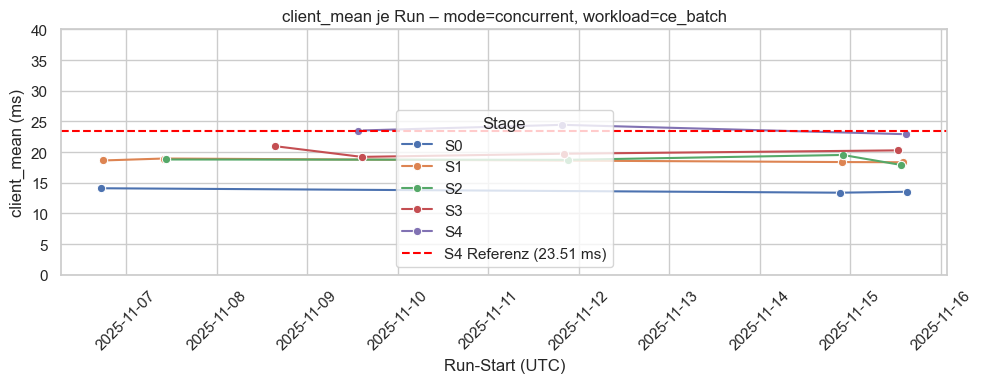

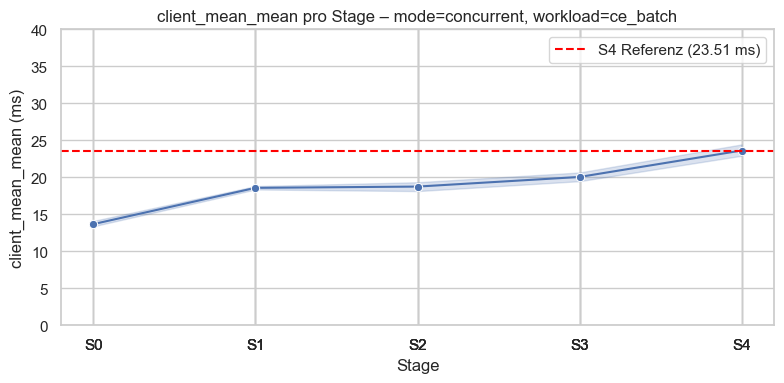

/var/folders/w_/y3xgslr95k5ddtwddqby08wc0000gn/T/ipykernel_3839/478439923.py:126: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=contrib, x="stage_label", y=delta_col, palette="Blues_d")


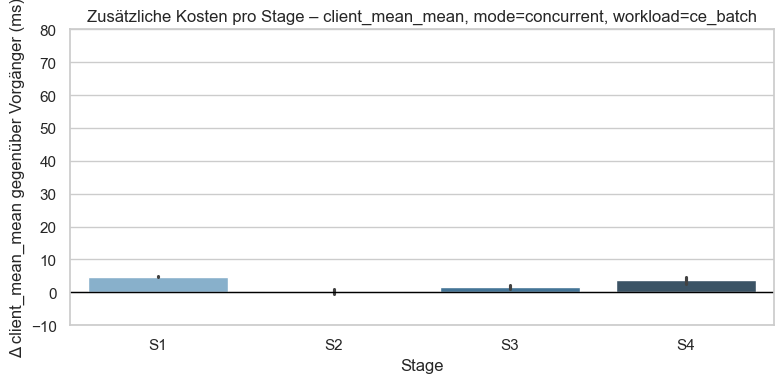

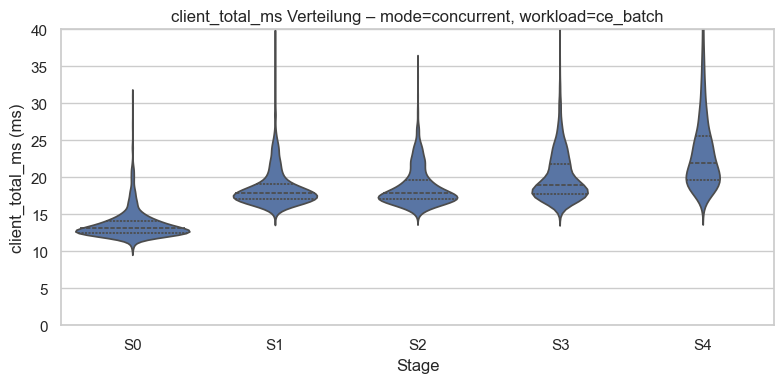

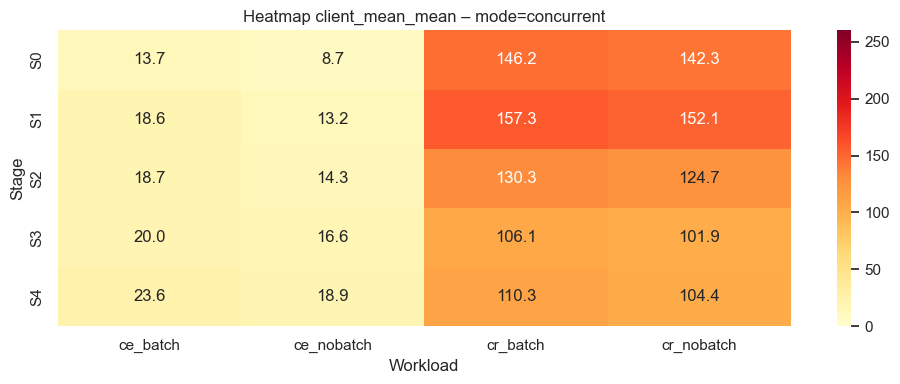

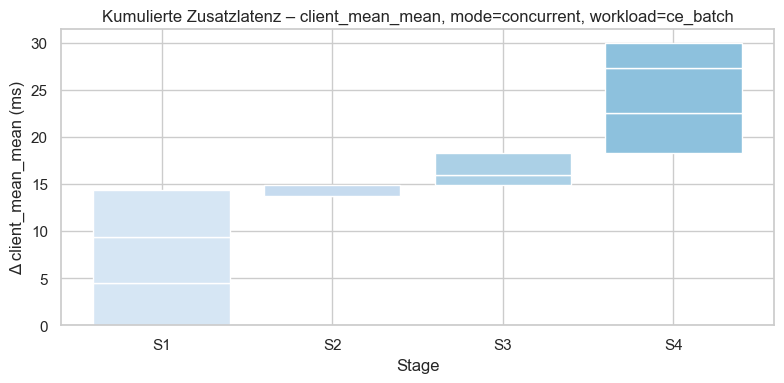

In [14]:
common_ylim_client = (0, 40)
common_ylim_server = (0, 40)

plot_run_mean_timeseries(
    run_means,
    metric="client_mean",
    mode="concurrent",
    workload="ce_batch",
    reference_stage="S4",
    ylim=common_ylim_client,
)
plot_phase_means(
    category_summary,
    metric="client_mean_mean",
    mode="concurrent",
    workload="ce_batch",
    reference_stage="S4",
    ylim=common_ylim_client,
)
plot_phase_contributions(
    phase_deltas,
    metric="client_mean_mean",
    mode="concurrent",
    workload="ce_batch",
    ylim=(-10, 80),
)
plot_stage_distribution(
    samples,
    metric="client",
    mode="concurrent",
    workload="ce_batch",
    kind="violin",
    ylim=common_ylim_client,
)
plot_phase_heatmap(
    category_summary,
    metric="client_mean_mean",
    mode="concurrent",
    vmin=0,
    vmax=260,
)
plot_cumulative_phase_deltas(
    phase_deltas,
    metric="client_mean_mean",
    mode="concurrent",
    workload="ce_batch",
)


### Beispiel-Aufrufe

Passe `workload`, `mode`, `metric` oder `reference_stage` an, um unterschiedliche Perspektiven zu erhalten (z. B. `ce_batch` vs. `cr_batch`).


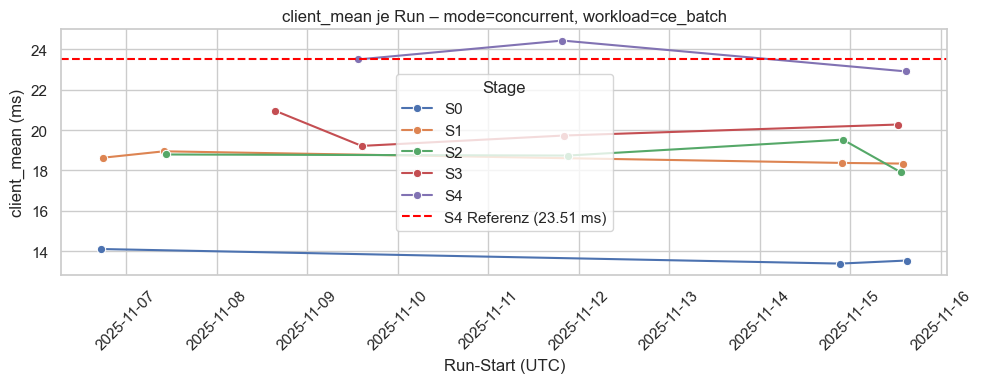

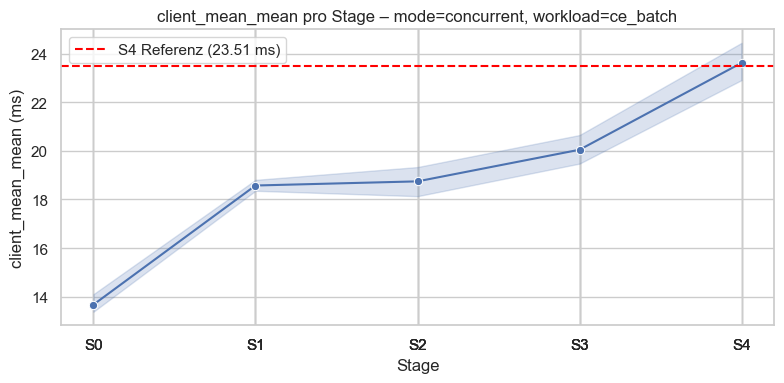

/var/folders/w_/y3xgslr95k5ddtwddqby08wc0000gn/T/ipykernel_3839/478439923.py:126: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=contrib, x="stage_label", y=delta_col, palette="Blues_d")


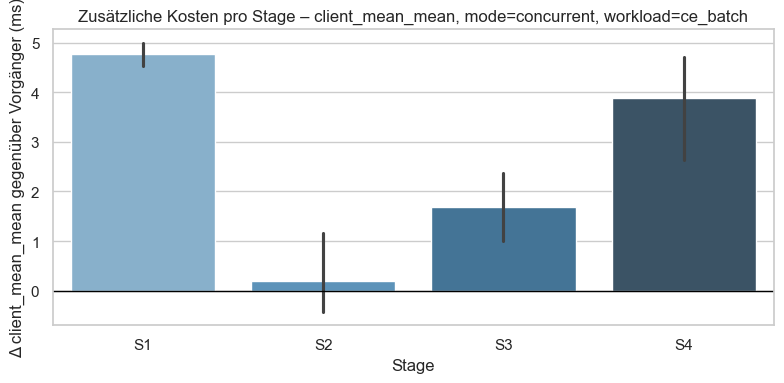

In [15]:
plot_run_mean_timeseries(run_means, metric="client_mean", mode="concurrent", workload="ce_batch", reference_stage="S4")
plot_phase_means(category_summary, metric="client_mean_mean", mode="concurrent", workload="ce_batch", reference_stage="S4")
plot_phase_contributions(phase_deltas, metric="client_mean_mean", mode="concurrent", workload="ce_batch")
